## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## import the required libraries

In [1]:

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from os import listdir
from os.path import isfile, join
import collections

%matplotlib qt

# Define global values
ret, mtx, dist, rvecs, tvecs = None, None, None, None, None

Wrote the image: calibration17.jpg
Wrote the image: calibration7.jpg
Wrote the image: calibration10.jpg
Wrote the image: calibration1.jpg
Wrote the image: calibration19.jpg
Wrote the image: calibration4.jpg
Wrote the image: calibration16.jpg
Wrote the image: calibration20.jpg
Wrote the image: calibration13.jpg
Wrote the image: calibration6.jpg
Wrote the image: calibration11.jpg
Wrote the image: calibration9.jpg
Wrote the image: calibration18.jpg
Wrote the image: calibration2.jpg
Wrote the image: calibration12.jpg
Wrote the image: calibration8.jpg
Wrote the image: calibration15.jpg
Wrote the image: calibration5.jpg
Wrote the image: calibration14.jpg
Wrote the image: calibration3.jpg


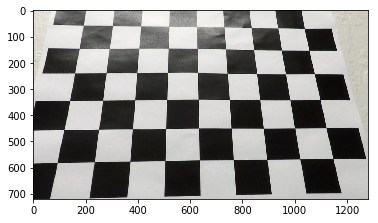

In [2]:
only_once_camera_calibrate = True

def computeCalibrationAndUndistort(img_input_dir, img_output_dir):
       
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(img_input_dir + 'calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    images = [f for f in listdir(img_input_dir) if isfile(join(img_input_dir, f))]
    # call undistort
    for fname in images:
        img = mpimg.imread(img_input_dir + fname)
        # product the undistort image
        dst = cal_undistort(img, objpoints, imgpoints)
        # plt.figure()
        plt.imshow(dst)
        cv2.imwrite(img_output_dir + fname, dst)
        print("Wrote the image: " + fname)
            
def cal_undistort(img, objpoints, imgpoints):
    global ret, mtx, dist, rvecs, tvecs
    
    if only_once_camera_calibrate:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
        
if __name__ == '__main__':
    # undistort the camera_cal directory images and put them iinto output_images
    computeCalibrationAndUndistort(img_input_dir = "camera_cal/", img_output_dir = "output_images/")
    
#cv2.destroyAllWindows()

## Distortion Correction

In [9]:
# undistort the test_images directory images and put them into test_images_output
### Loading the distortion coefficients
coeff = pickle.load(open("wide_dist_pickle.p","rb"))
mtx = coeff['mtx']
dist = coeff['dist']    

images = [f for f in listdir("test_images/") if isfile(join("test_images/", f))]

for fname in images:
        img = mpimg.imread("test_images/" + fname)
        undist = cv2.undistort(img,mtx,dist,None,mtx)
        cv2.imwrite("test_images_output/distortion-corrected/" + fname, undist)
        

## Image Thresholding

In [2]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(hls, index, thresh=(0, 255)):
    # hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,index]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#hls_binary = hls_select(image, thresh=(90, 255))

def combine_binary(undist):
    ksize = 5
            
    gradx = abs_sobel_thresh(undist, orient='x', thresh_min=5, thresh_max=100)
    grady = abs_sobel_thresh(undist, orient='y', thresh_min=30, thresh_max=100)
  
    mag_binary = mag_thresh(undist, sobel_kernel=9, mag_thresh=(20, 100))
    #dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2))
    dir_binary = dir_threshold(undist, sobel_kernel=21, thresh=(-1.3,1.3))
    hls = cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)
    H_th = hls_select(hls,0,(5,50))
    S_th = hls_select(hls,2,(100,255))
    L_th = hls_select(hls,1,(0,101))
    combined = np.zeros_like(dir_binary)
    combined[ ((gradx == 1)  & (grady==1)) |( (mag_binary == 1) &(dir_binary==1)) | ((H_th==1)&(S_th==1) )] = 1
    combined=combined-L_th
    combined_binary = np.zeros_like(combined)
    combined_binary[combined>0]=1
    return combined_binary
    

In [4]:
### Loading the distortion coefficients
coeff = pickle.load(open("wide_dist_pickle.p","rb"))
mtx = coeff['mtx']
dist = coeff['dist'] 

images = [f for f in listdir("test_images/") if isfile(join("test_images/", f))]

for fname in images:
        img = mpimg.imread("test_images/" + fname)
        undist = cv2.undistort(img,mtx,dist,None,mtx)
        
        threshold_img = combine_binary(undist)
        print("Writing threshold image:"+fname)
        cv2.imwrite("test_images_output/img_threshold/" + fname, threshold_img*255)

Writing threshold image:test4.jpg
Writing threshold image:straight_lines1.jpg
Writing threshold image:test5.jpg
Writing threshold image:test1.jpg
Writing threshold image:test3.jpg
Writing threshold image:test2.jpg
Writing threshold image:straight_lines2.jpg
Writing threshold image:test6.jpg
